In [14]:
import sys
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import wmfdata as wmf

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [3]:
%matplotlib inline
# Customize Matplotlib styles
mpl.rcParams["font.size"] = 15
mpl.rcParams["figure.figsize"] = (16, 10)

In [4]:
# The time range for which to update. START is included, END is excluded.
START = "201805"
END = "201806"

In [5]:
all_wikis = wmf.utils.list_wikis()

In [6]:
isolate = "set session transaction isolation level read uncommitted;"

use_db = "use {db};"

editor_month = """
insert into staging.editor_month
select
  database() as wiki,
  str_to_date(concat(rev_month, "01"), "%Y%m%d") as month,
  local_user_id,
  ifnull(user_name, "") as user_name,
  ifnull(sum(edits), 0) as edits,
  ifnull(sum(content_edits), 0) as content_edits,
  ifnull(sum(edits * deleted), 0) as deleted_edits,
  ifnull(sum(mobile_web_edits), 0) as mobile_web_edits,
  ifnull(sum(mobile_app_edits), 0) as mobile_app_edits,
  ifnull(sum(visual_edits), 0) as visual_edits,
  ifnull(sum(ve_source_edits), 0) as ve_source_edits,
  if(ug_group = "bot" or ufg_group = "bot", 1, 0) as bot_flag,
  str_to_date(user_registration, "%Y%m%d%H%i%S") as user_registration
from
(
select
  left(rev_timestamp, 6) as `rev_month`,
  rev_user as `local_user_id`,
  count(*) as `edits`,
  sum(page_namespace = 0 or cn.namespace is not null) as content_edits,
  sum(
    ts_tags like "%mobile edit%" and
    (ts_tags like "%mobile web edit%" or ts_tags not like "%mobile app edit%")
  ) as mobile_web_edits,
  sum(ts_tags like "%mobile app edit%") as mobile_app_edits,
  sum(ts_tags like "%visualeditor%" and ts_tags not like "%visualeditor-wikitext%") as visual_edits,
  sum(ts_tags like "%visualeditor-wikitext%") as ve_source_edits,
  0 as `deleted`
from revision
left join page on rev_page = page_id
left join tag_summary on rev_id = ts_rev_id
left join datasets.content_namespaces cn on database() = wiki and page_namespace = namespace
where rev_timestamp >= "{start}" and rev_timestamp < "{end}"
group by left(rev_timestamp, 6), rev_user

union all

select
  left(ar_timestamp, 6) as `rev_month`,
  ar_user as `local_user_id`,
  count(*) as `edits`,
  sum(ar_namespace = 0 or cn.namespace is not null) as content_edits,
  sum(
    ts_tags like "%mobile edit%" and
    (ts_tags like "%mobile web edit%" or ts_tags not like "%mobile app edit%")
  ) as mobile_web_edits,
  sum(ts_tags like "%mobile app edit%") as mobile_app_edits,
  sum(ts_tags like "%visualeditor%" and ts_tags not like "%visualeditor-wikitext%") as visual_edits,
  sum(ts_tags like "%visualeditor-wikitext%") as ve_source_edits,
  1 as `deleted`
from archive
left join tag_summary on ar_rev_id = ts_rev_id
left join datasets.content_namespaces cn on database() = wiki and ar_namespace = namespace
where ar_timestamp >= "{start}" and ar_timestamp < "{end}"
group by left(ar_timestamp, 6), ar_user
) revs
left join user on local_user_id = user_id
left join user_groups on local_user_id = ug_user and ug_group = "bot"
left join user_former_groups on local_user_id = ufg_user and ufg_group = "bot"
group by month, local_user_id;
"""

In [7]:
for wiki in all_wikis:
    init = time.perf_counter()
    wmf.mariadb.run([
        isolate,
        use_db.format(db = wiki),
        editor_month.format(start = START, end = END)
    ])
    elapsed = time.perf_counter() - init
    wmf.utils.print_err("{} completed in {:0.0f} s".format(wiki, elapsed))

aawiki completed in 0 s
aawikibooks completed in 0 s
aawiktionary completed in 0 s
abwiki completed in 2 s
abwiktionary completed in 0 s
acewiki completed in 1 s
adywiki completed in 0 s
afwiki completed in 1 s
afwikibooks completed in 0 s
afwikiquote completed in 0 s
afwiktionary completed in 0 s
akwiki completed in 1 s
akwikibooks completed in 0 s
akwiktionary completed in 0 s
alswiki completed in 1 s
alswikibooks completed in 0 s
alswikiquote completed in 0 s
alswiktionary completed in 0 s
amwiki completed in 0 s
amwikiquote completed in 0 s
amwiktionary completed in 0 s
angwiki completed in 0 s
angwikibooks completed in 0 s
angwikiquote completed in 0 s
angwikisource completed in 0 s
angwiktionary completed in 0 s
anwiki completed in 1 s
anwiktionary completed in 0 s
arcwiki completed in 1 s
arwiki completed in 153 s
arwikibooks completed in 1 s
arwikinews completed in 1 s
arwikiquote completed in 1 s
arwikisource completed in 2 s
arwikiversity completed in 1 s
arwiktionary complet

# Quality checks

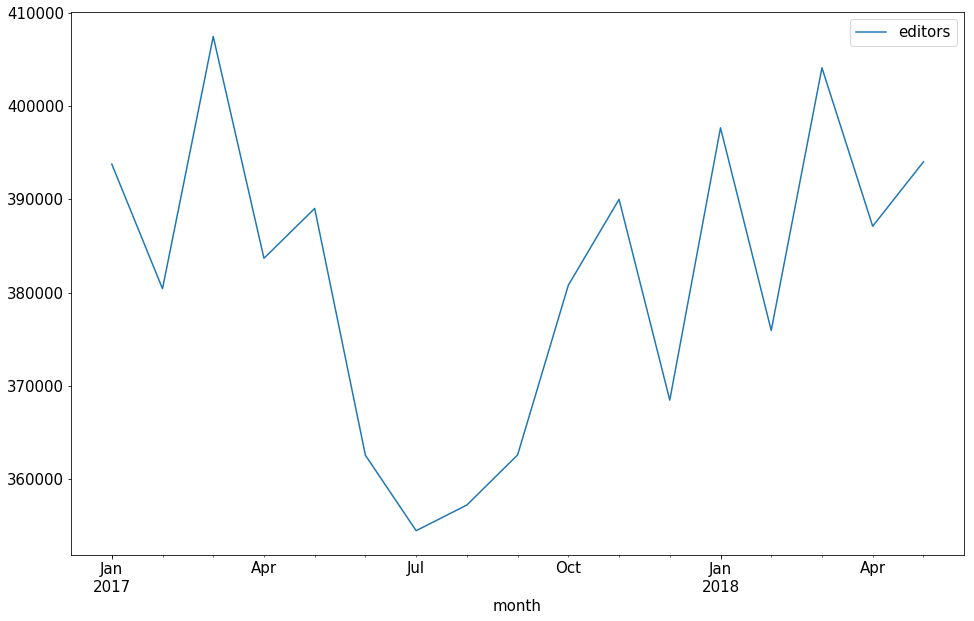

In [16]:
eds = wmf.mariadb.run("""
    select month, count(*) as editors
    from editor_month 
    where month >= "2017-01-01"
    group by month
""")

eds["month"] = eds["month"].apply(pd.to_datetime)
eds = eds.set_index("month")
eds.plot();

In [38]:
v_active = wmf.mariadb.run("""
    select month, count(*) as very_active_editors
    from editor_month 
    where month >= "2017-01-01" and content_edits >= 100
    group by month
""")

v_active["month"] = v_active["month"].apply(pd.to_datetime)
v_active = v_active.set_index("month")

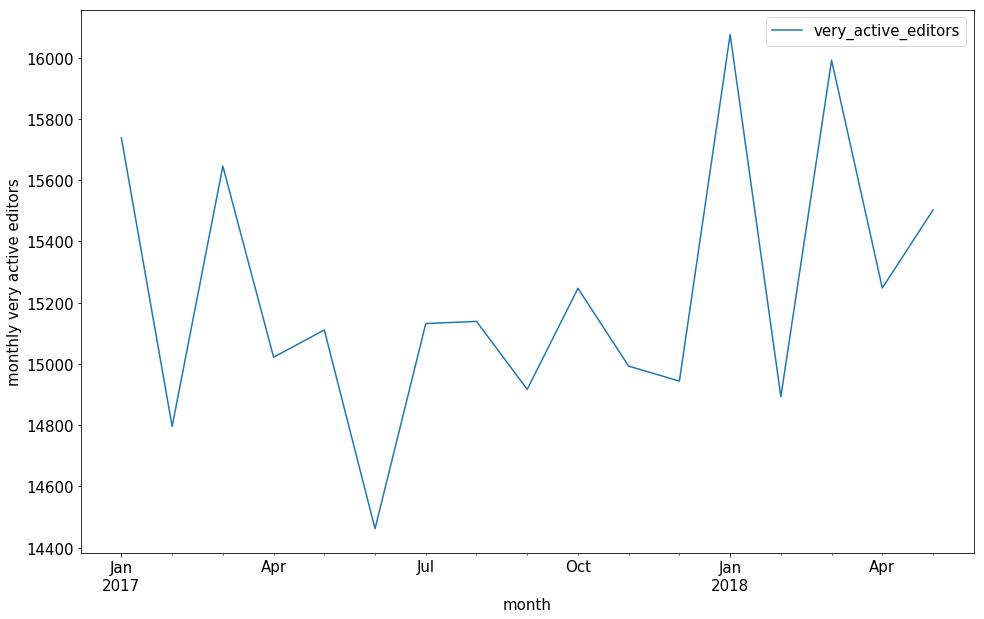

In [41]:
v_active.plot()
plt.ylabel("monthly very active editors");

In [43]:
wikis = wmf.mariadb.run("""
    select month, wiki, count(*) 
    from editor_month 
    where month >= "2017-11-01" and wiki in ("arwiki", "dewiki", "enwiki", "kowiki", "zhwiki")
    group by wiki, month
""")

wikis["month"] = wikis["month"].apply(pd.to_datetime)
wikis = wikis.set_index("month")
wikis = wikis.pivot(columns="wiki")
wikis.columns = wikis.columns.droplevel(0)

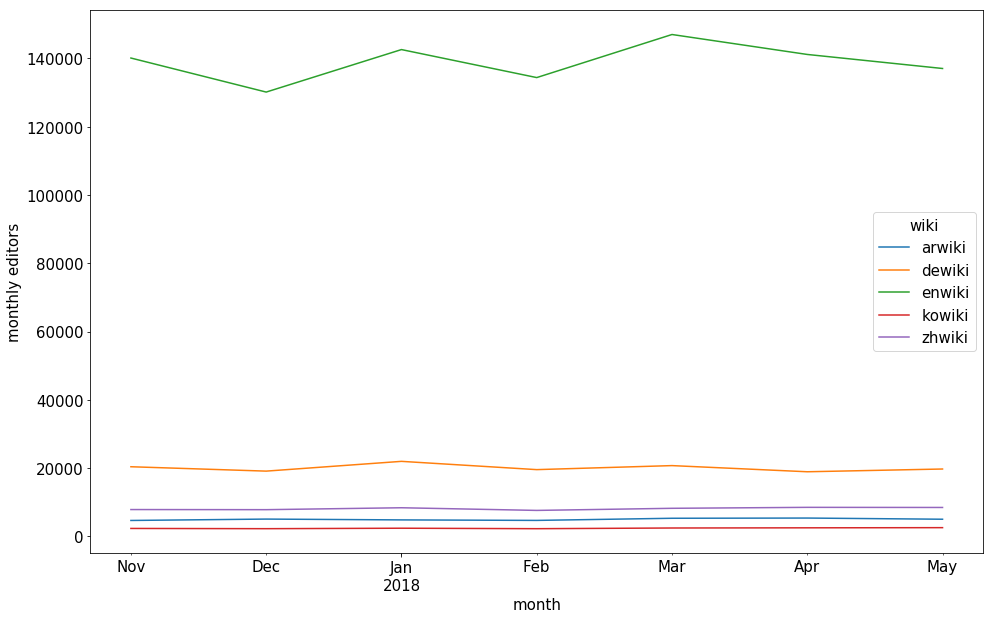

In [45]:
wikis.plot()
plt.ylabel("monthly editors");